# Plot the Scatter Plot and Time Series Errors

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [4]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

In [5]:
import sys
sys.path.append("../neuralhydrology")

from neuralhydrology.evaluation.metrics import nse, mse, rmse, kge, fdc_fms, fdc_fhv, fdc_flv, calculate_all_metrics, calculate_metrics

# Read in the CAMELS data

In [6]:
# read in the training data
dynamic = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
dynamic['station_id'] = dynamic['station_id'].astype(int)
ds = dynamic

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Read AWS Trained Models

In [7]:
# ealstm_less_vars = pd.read_csv(data_dir / "runs/ealstm_less_vars_2004_1707_1424/results_ealstm_less_vars_2004_1707_1424_E015.csv")
ealstm_preds = xr.open_dataset(data_dir / "RUNOFF/ealstm_epoch30_ensemble2/results.nc")
ealstm_preds["station_id"] = [int(sid) for sid in ealstm_preds["station_id"]]
ealstm_preds = ealstm_preds.rename({"discharge_spec_obs": "obs", "discharge_spec_sim": "sim"})
ealstm_df = ealstm_preds.to_dataframe().reset_index()

In [8]:
lstm_ensemble_df = pd.read_csv("/cats/datastore/data/runs/ensemble/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_ensemble_df["time"] = pd.to_datetime(lstm_ensemble_df["time"])
lstm_ensemble = lstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()
lstm_preds = lstm_ensemble
lstm_df = lstm_preds.to_dataframe().reset_index()

In [9]:
metric_df = pd.read_csv(data_dir / "runs/ensemble/metric_df.csv", index_col=0)
metric_df.columns = [c.lower() for c in metric_df.columns]
metric_df.head()

,station_id,nse,kge,mse,fhv,fms,flv
0,10002,0.898328,0.857653,0.229347,-10.042169,20.175607,4.281218
1,10003,0.926555,0.881110,0.111980,-6.074578,1.342742,28.237229
2,1001,0.876090,0.920412,0.509755,3.647934,-23.746845,70.234474
3,101002,0.757246,0.647206,0.300506,-25.176707,-4.734227,73.409471
4,101005,0.824926,0.796430,0.208704,-18.346511,1.971726,45.197245


# FUSE Data

In [10]:
all_paths = [d for d in (data_dir / "RUNOFF/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "RUNOFF/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "RUNOFF/ALL_fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "RUNOFF/ALL_fuse_ds.nc")

In [11]:
fuse_ds = fuse_ds.sel(time=slice('1998-01-01', '2009-01-01'))

In [12]:
# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["discharge_spec"]
).rename("obs")
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)

In [13]:
fuse_data

<xarray.Dataset>
Dimensions:          (station_id: 519, time: 4018)
Coordinates:
  * station_id       (station_id) int64 1001 2001 2002 ... 101005 102001 106001
  * time             (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
Data variables:
    SimQ_TOPMODEL    (station_id, time) float64 ...
    SimQ_ARNOVIC     (station_id, time) float64 ...
    SimQ_PRMS        (station_id, time) float64 ...
    SimQ_SACRAMENTO  (station_id, time) float64 ...
    obs              (time, station_id) float64 ...

# Match Stations / Times

In [14]:
all_stations_lstm = np.isin(lstm_preds.station_id, fuse_data.station_id)
all_stations_ealstm = np.isin(ealstm_preds.station_id, fuse_data.station_id)

In [15]:
# lstm_preds = lstm_preds.sel(station_id=all_stations_lstm, time=fuse_data.time)
# ealstm_preds = ealstm_preds.sel(station_id=all_stations_ealstm, time=fuse_data.time)

# Errors

In [16]:
from scripts.drafts.calculate_error_scores import calculate_errors, error_func

In [17]:
ealstm_metric_df = calculate_errors(ealstm_preds).set_index("station_id")
lstm_metric_df = calculate_errors(lstm_preds).set_index("station_id")

In [18]:
metric_df["rmse"] = np.sqrt(metric_df["mse"])
lstm_metric_df["rmse"] = np.sqrt(lstm_metric_df["mse"])
ealstm_metric_df["rmse"] = np.sqrt(ealstm_metric_df["mse"])
display(metric_df.set_index("station_id").sort_index().head())
display(lstm_metric_df.sort_index().head())

,nse,kge,mse,fhv,fms,flv,rmse
station_id,,,,,,,
1001,0.876090,0.920412,0.509755,3.647934,-23.746845,70.234474,0.713971
2001,0.796159,0.737755,1.295476,-23.338750,-8.885240,8.945649,1.138190
2002,0.799168,0.721571,2.248968,-26.614591,-20.047770,54.950795,1.499656
3003,0.878744,0.851921,4.253649,-13.508330,-20.236829,54.121467,2.062438
4001,0.872644,0.860455,1.789749,-4.687964,-18.653824,39.811433,1.337815


,nse,kge,mse,bias,log_nse,inv_kge,rmse
station_id,,,,,,,
1001,0.876090,0.920412,0.509755,4.266320,0.785360,0.920412,0.713971
2001,0.796159,0.737755,1.295476,-12.189085,0.885491,0.737755,1.138190
2002,0.799168,0.721571,2.248968,-7.375567,0.846839,0.721571,1.499656
3003,0.878744,0.851921,4.253648,-0.086631,0.875849,0.851921,2.062437
4001,0.872644,0.860455,1.789749,-3.644160,0.801445,0.860455,1.337815


# FUSE - Calculate from Sim

In [19]:
from scripts.drafts.calculate_error_scores import FuseErrors

In [20]:
f = FuseErrors(fuse_data)
fuse_errors = f.fuse_errors
fuse_metric_df = fuse_errors

nse: 4it [00:09,  2.28s/it]
kge: 4it [00:09,  2.47s/it]
bias: 4it [00:06,  1.54s/it]
rmse: 4it [00:06,  1.58s/it]


In [21]:
fuse_bias = f.get_metric_df("bias")
fuse_nse_df = f.get_metric_df("nse")
fuse_kge_df = f.get_metric_df("kge")
fuse_kge_df.head()

,PRMS,Sacramento,TOPMODEL,VIC,Name
1001,0.850647,0.856466,0.813894,0.786482,Wick at Tarroul
2001,0.748769,0.742688,0.758969,0.698891,Helmsdale at Kilphedir
2002,0.810254,0.734603,0.756657,0.685371,Brora at Bruachrobie
3003,0.889991,0.887535,0.840244,0.814423,Oykel at Easter Turnaig
4001,0.828668,0.793088,0.733907,0.841072,Conon at Moy Bridge


In [22]:
model = "VIC"
vic_data = f.get_model_df(model)
vic_data.head()

,bias,kge,nse,rmse,Name
1001,12.112858,0.786482,0.766521,0.980059,Wick at Tarroul
2001,-2.899249,0.698891,0.685077,1.414721,Helmsdale at Kilphedir
2002,-2.646902,0.685371,0.681148,1.889598,Brora at Bruachrobie
3003,1.690727,0.814423,0.799981,2.648892,Oykel at Easter Turnaig
4001,-3.086921,0.841072,0.818019,1.599187,Conon at Moy Bridge


# Create Plotting Algos

In [23]:
from typing import Optional, List, Tuple, Dict

def plot_station_scatter(
    df: pd.DataFrame, 
    station_id: str, 
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    target_var: str = 'discharge_spec',
    station_name: Optional[str] = None,
    color_by_season: bool = None,
):
    # select station
    d = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = plt.gcf()
    
    if not color_by_season:
        # plot scatter
        ax.plot(d[target_var], d.preds, 'kx', alpha=0.6, label='Data Point')
    else:
        seasons = ds.sel(time=d.index)["time.season"].values
        d["season"] = seasons
        for ix, season in enumerate(d.season.unique()):
            ax.scatter(
                d.loc[d["season"] == season, target_var], 
                d.loc[d["season"] == season, "preds"], 
                color=sns.color_palette()[ix], 
                alpha=0.6, 
                label=season,
                marker="x"
            )
            sns.regplot(
                d.loc[d["season"] == season, target_var], 
                d.loc[d["season"] == season, "preds"], 
                color=sns.color_palette()[ix],
                ax=ax,
                scatter=False,
                ci=None,
            )
    # plot 1:1 line
    max_val = max(ax.get_xlim()[-1], ax.get_ylim()[-1])
    line_1_1_x = np.linspace(0, max_val, 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line')
    
    # set the xylim
    ax.set_ylim(0, max_val)
    ax.set_xlim(0, max_val)

    ax.set_xlabel('Observed $[mm d^{-1} km^{-2}]$')
    ax.set_ylabel('Predicted $[mm d^{-1} km^{-2}]$')
    title = f'Station {station_id}' + f" {station_name}" if station_name is not None else f'Station {station_id}'
    ax.set_title(title)

    ax.legend();
    
    if False:
        # making the plot pretty
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                          + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return fig, ax


def plot_station(
    df: pd.DataFrame, 
    station_id: str, 
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    station_name: Optional[str] = None,
    plot_years: Optional[List[int]] = None,
):
    """Plot the Observed vs. Preds for the station_id"""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    # plot the station
    if plot_years is None:
        data = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
        ax.plot(np.arange(len(data)), data["preds"], label="Sim")
        ax.plot(np.arange(len(data)), data["discharge_spec"], label="Obs", ls=":", color="k")
        #.plot(ax=ax)
    else:
        data = (
            df.loc[np.isin(df.index.year, plot_years)]
            .query(f"station_id == '{station_id}'")
            .drop(columns='station_id')
        )  # .plot(ax=ax)
        ax.plot(np.arange(len(data)), data["preds"], label="Sim")
        ax.plot(np.arange(len(data)), data["discharge_spec"], label="Obs", ls=":", color="k")

    # get the error metrics
    try:
        rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    except AttributeError:
        rmse_val = np.nan
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    kge_val = metrics_df.query(f"station_id == '{station_id}'").kge.values[0]
    # set the title
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    ax.set_title(f"{station_title}\nRMSE: {rmse_val:.2f} NSE: {nse_val:.2f} KGE: {kge_val:.2f}")
    
    return fig, ax


def plot_catchment_time_series(
    df: pd.DataFrame,
    metrics_df: pd.DataFrame,
    catchment_ids: List[str],
    catchment_names: List[str],
    plot_years: List[int] = [2011],
    scale: float = 0.8,
    color_by_season: bool = False,
):
    n_plots = len(catchment_ids)
    station_map = dict(zip(catchment_ids, catchment_names))
    fig, axs = plt.subplots(n_plots, 2, figsize=(12*scale, 6*scale*n_plots))

    for ix, (station_id, station_name) in enumerate(zip(catchment_ids, catchment_names)):
    #     fig, axs = plt.subplots(1, 2, figsize=(12*scale, 6*scale))
        try:
            plot_station(df, station_id, metrics_df, ax=axs[ix, 0], station_name=station_name, plot_years=plot_years)
            axs[ix, 0].legend()
            plot_station_scatter(df, station_id, metrics_df, axs[ix, 1], color_by_season=color_by_season)
        except IndexError:
            # the axes are one dimensional
            plot_station(df, station_id, metrics_df, ax=axs[0], station_name=station_name, plot_years=plot_years)
            plot_station_scatter(df, station_id, metrics_df, axs[1], color_by_season=color_by_season)
        except TypeError:
            print(f"** {station_name} data does not exist in the predictions! **")

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    return fig, axs

# Get the median basins etc.

In [24]:
assert (data_dir / "RUNOFF/all_nse.csv").exists()
assert (data_dir / "RUNOFF/all_bias.csv").exists()

all_nse = pd.read_csv((data_dir / "RUNOFF/all_nse.csv"))
all_bias = pd.read_csv((data_dir / "RUNOFF/all_bias.csv"))

# all_nse

In [25]:
median = all_nse.loc[all_nse['LSTM'] == all_nse['LSTM'].median()]
min_ = all_nse.loc[all_nse['LSTM'] == all_nse['LSTM'].min()]
max_ = all_nse.loc[all_nse['LSTM'] == all_nse['LSTM'].max()]

median_station = (median["Station ID"].values, median.Name.values)
min_station = (min_["Station ID"].values, min_.Name.values)
max_station = (max_["Station ID"].values, max_.Name.values)

pd.concat([median, min_, max_])

,Station ID,Name,LSTM,EALSTM,CLASSIC,JULES,PRMS,Sacramento,TOPMODEL,VIC
10,54057,Severn at Haw Bridge,0.936800,0.923976,0.78,0.72,0.880677,0.920232,0.882238,0.877385
3,27034,Ure at Kilgram Bridge,0.882438,0.874830,0.78,0.75,0.846070,0.852412,0.841413,0.844337
5,39001,Thames at Kingston,0.958940,0.938562,0.81,0.82,0.686639,0.882496,0.752798,0.782795


In [26]:
summary_stations = np.vstack([median_station, min_station, max_station]).reshape(3, 2)

# Show basin with the max variance of performance

In [27]:
# find the basin with greatest variance
station_max_variance = all_nse.set_index("Station ID").drop(["Name", "JULES", "CLASSIC"], axis=1).std(axis=1).idxmax()
station_med_variance = all_nse.set_index("Station ID")[all_nse.set_index("Station ID").drop(["Name", "JULES", "CLASSIC"], axis=1).std(axis=1) == all_nse.set_index("Station ID").drop(["Name", "JULES", "CLASSIC"], axis=1).std(axis=1).median()].index
all_nse.set_index("Station ID").loc[station_max_variance]

Name          Avon at Knapp Mill
LSTM                    0.893129
EALSTM                  0.924441
CLASSIC                      0.6
JULES                      -0.07
PRMS                    0.837635
Sacramento              0.893386
TOPMODEL                0.536147
VIC                     0.907952
Name: 43021, dtype: object

In [65]:
def get_all_data_for_basins(stations: np.ndarray) -> pd.DataFrame:
    df = lstm_preds.sel(station_id=stations).to_dataframe().rename({"sim": "LSTM"}, axis=1)
    e_df = (
        ealstm_preds.sel(station_id=stations).to_dataframe()
        .drop("obs", axis=1).rename({"sim": "EALSTM"}, axis=1)
    ).reset_index("station_id").drop("station_id", axis=1)
    f_df = (
        fuse_ds.sel(station_id=stations[np.isin(stations, fuse_ds.station_id)]).to_dataframe()
    ).reset_index("station_id").drop("station_id", axis=1)
    
    data = (df.join(e_df).join(f_df)).reset_index().set_index("station_id")

    def fixC(colname: str) -> str:
        cname = colname.replace("SimQ_", "")
    #     cname = "VIC" if cname == "ARNOVIC" else cname
    #     cname = "Sacramento" if cname == "SACRAMENTO" else cname
        return cname
    
    data.columns = [fixC(c) for c in data.columns]
    return data


In [66]:
stations = np.array([station_max_variance])
df = get_all_data_for_basins(stations=stations).reset_index().set_index(["time"]).drop("station_id", axis=1)

df.head()

,obs,LSTM,EALSTM,TOPMODEL,ARNOVIC,PRMS,SACRAMENTO
time,,,,,,,
1998-01-01,1.59,1.773642,1.725273,1.4756,1.4522,1.5176,1.5968
1998-01-02,1.98,2.597594,2.602101,1.8085,1.6703,1.6894,1.7735
1998-01-03,2.25,3.039324,2.825876,2.2176,1.9110,1.9032,2.0023
1998-01-04,2.42,3.343164,3.161276,2.6319,2.1500,2.1282,2.2573
1998-01-05,2.67,3.763503,3.328459,3.0364,2.3855,2.3548,2.5284


In [30]:
from typing import Optional
import matplotlib.dates as mdates


static_df = static.to_dataframe()

# ax2 = ax.twinx()
# ax2.bar(x, -precipitation, 0.1)
# ax2.invert_yaxis()


def plot_station_hydrograph(
    data: pd.DataFrame, station_id: int, plot_conceptual: bool = True, ax: Optional = None,
    
):
    assert all(np.isin(["time", "LSTM", "EALSTM", "obs"], data.columns))
    station_name = static_df.loc[station_id, "gauge_name"]
    precip = dynamic.sel(time=data["time"].values, station_id=station_id)["precipitation"].drop("station_id", axis=1)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 4))
    else:
        fig = plt.gcf()
        
    ax.plot(data["time"], data["LSTM"], color=sns.color_palette()[0], label="LSTM", alpha=1, linewidth=2)
    ax.plot(data["time"], data["EALSTM"], color=sns.color_palette()[1], label="EA LSTM", alpha=1, linewidth=2)
    if plot_conceptual:
        ax.plot(data["time"], data["TOPMODEL"], label="TOPMODEL", alpha=0.5, linewidth=1, color=sns.color_palette()[2])
        ax.plot(data["time"], data["ARNOVIC"], label="VIC", alpha=0.5, linewidth=1, color=sns.color_palette()[3])
        ax.plot(data["time"], data["PRMS"], label="PRMS", alpha=0.5, linewidth=1, color=sns.color_palette()[4])
        ax.plot(data["time"], data["SACRAMENTO"], label="Sacramento", alpha=0.5, linewidth=1, color=sns.color_palette()[5])

    ax.plot(data["time"], data["obs"], color="k", ls=":", label="Observed")
    ax.legend()
    
    # Plot the rainfall too
    ax2 = ax.twinx()
    ax2.bar(data["time"], precip, alpha=0.4)
    ax2.set_ylim([0, precip.max() + 5*precip.std()])
    ax2.set_yticklabels([])
    ax2.set_yticks([])
    ax2.invert_yaxis()

    ax.set_title(f"Station: {station_name} - {station_id}")  # \nNSE: {} -- Bias: {} -- {}
    ax.set_xlabel("Time")
    ax.set_ylabel("Specific Discharge")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()

    sns.despine()
    
    return f, ax

In [31]:
# f, ax=plt.subplots()
# precip = dynamic["precipitation"].sel(time=data.time.values, station_id=station_max_variance).to_dataframe().drop("station_id", axis=1)
# display(precip.head())
# ax.bar(precip.index, precip["precipitation"])
# ax.invert_yaxis()

In [72]:
# stations
# get_all_data_for_basins(stations=station)

NameError: name 'station' is not defined

In [75]:
station = all_nse["Station ID"][0]
df = get_all_data_for_basins(stations=station).reset_index().set_index(["time"]).drop("station_id", axis=1)
df.head()

KeyError: 'Requested level (station_id) does not match index name (time)'

> /home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/pandas/core/indexes/base.py(1415)_validate_index_level()
   1413                 )
   1414         elif level != self.name:
-> 1415             raise KeyError(
   1416                 f"Requested level ({level}) does not match index name ({self.name})"
   1417             )



ipdb>  u


> /home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/pandas/core/indexes/base.py(1420)_get_level_number()
   1418 
   1419     def _get_level_number(self, level):
-> 1420         self._validate_index_level(level)
   1421         return 0
   1422 



ipdb>  u


> /home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/pandas/core/frame.py(4565)<listcomp>()
   4563             if not isinstance(level, (tuple, list)):
   4564                 level = [level]
-> 4565             level = [self.index._get_level_number(lev) for lev in level]
   4566             if len(level) < self.index.nlevels:
   4567                 new_index = self.index.droplevel(level)



ipdb>  u


> /home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/pandas/core/frame.py(4565)reset_index()
   4563             if not isinstance(level, (tuple, list)):
   4564                 level = [level]
-> 4565             level = [self.index._get_level_number(lev) for lev in level]
   4566             if len(level) < self.index.nlevels:
   4567                 new_index = self.index.droplevel(level)



ipdb>  u


> <ipython-input-60-d4664e799141>(2)get_all_data_for_basins()
      1 def get_all_data_for_basins(stations: np.ndarray) -> pd.DataFrame:
----> 2     df = lstm_preds.sel(station_id=stations).to_dataframe().rename({"sim": "LSTM"}, axis=1).reset_index("station_id")
      3     e_df = (
      4         ealstm_preds.sel(station_id=stations).to_dataframe()
      5         .drop("obs", axis=1).rename({"sim": "EALSTM"}, axis=1)



ipdb>  lstm_preds.sel(station_id=stations).to_dataframe()


            station_id   obs       sim
time                                  
1998-01-01       12002  4.92  3.618209
1998-01-02       12002  4.60  6.317567
1998-01-03       12002  6.69  5.550692
1998-01-04       12002  4.57  4.855802
1998-01-05       12002  3.33  3.199364
...                ...   ...       ...
2008-12-27       12002  1.55  1.639676
2008-12-28       12002  1.43  1.544191
2008-12-29       12002  1.36  1.475837
2008-12-30       12002  1.16  1.269328
2008-12-31       12002  0.88  1.199905

[4018 rows x 3 columns]


ipdb>  q


> /home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/pandas/core/reshape/merge.py(2024)_items_overlap_with_suffix()
   2022 
   2023     if not lsuffix and not rsuffix:
-> 2024         raise ValueError(
   2025             "columns overlap but no suffix specified: "
   2026             "{rename}".format(rename=to_rename)



ipdb>  u


> /home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/pandas/core/reshape/merge.py(648)get_result()
    646         lsuf, rsuf = self.suffixes
    647 
--> 648         llabels, rlabels = _items_overlap_with_suffix(
    649             ldata.items, lsuf, rdata.items, rsuf
    650         )



ipdb>  u


> /home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/pandas/core/reshape/merge.py(88)merge()
     86         validate=validate,
     87     )
---> 88     return op.get_result()
     89 
     90 



ipdb>  u


> /home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/pandas/core/frame.py(7224)_join_compat()
   7222 
   7223         if isinstance(other, DataFrame):
-> 7224             return merge(
   7225                 self,
   7226                 other,



ipdb>  u


> /home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/pandas/core/frame.py(7208)join()
   7206         5  K5  A5  NaN
   7207         """
-> 7208         return self._join_compat(
   7209             other, on=on, how=how, lsuffix=lsuffix, rsuffix=rsuffix, sort=sort
   7210         )



ipdb>  u


> <ipython-input-28-b0b4bad8a413>(10)get_all_data_for_basins()
      8         fuse_ds.sel(station_id=stations[np.isin(stations, fuse_ds.station_id)]).to_dataframe()
      9     )
---> 10     data = (df.join(e_df).join(f_df)).reset_index().set_index("station_id")
     11 
     12     def fixC(colname: str) -> str:



ipdb>  df.head()


            station_id   obs      LSTM
time                                  
1998-01-01       12002  4.92  3.618209
1998-01-02       12002  4.60  6.317567
1998-01-03       12002  6.69  5.550692
1998-01-04       12002  4.57  4.855802
1998-01-05       12002  3.33  3.199364


ipdb>  f_df.head()


                       SimQ_TOPMODEL  SimQ_ARNOVIC  SimQ_PRMS  SimQ_SACRAMENTO
station_id time                                                               
12002      1998-01-01         3.8720        5.7673     5.3027           5.0051
           1998-01-02         5.6070        6.7156     6.3279           6.3668
           1998-01-03         6.1154        6.8587     6.5773           6.6946
           1998-01-04         5.7523        6.3508     6.2880           6.3009
           1998-01-05         4.2524        5.0442     5.2585           4.9862


ipdb>  (df.join(e_df).join(f_df)).head()


*** ValueError: columns overlap but no suffix specified: Index(['station_id'], dtype='object')


ipdb>  e_df.head()


            station_id    EALSTM
time                            
1998-01-01       12002  3.419044
1998-01-02       12002  5.356227
1998-01-03       12002  4.863574
1998-01-04       12002  4.625275
1998-01-05       12002  3.187255


ipdb>  df.head()


            station_id   obs      LSTM
time                                  
1998-01-01       12002  4.92  3.618209
1998-01-02       12002  4.60  6.317567
1998-01-03       12002  6.69  5.550692
1998-01-04       12002  4.57  4.855802
1998-01-05       12002  3.33  3.199364


ipdb>  q


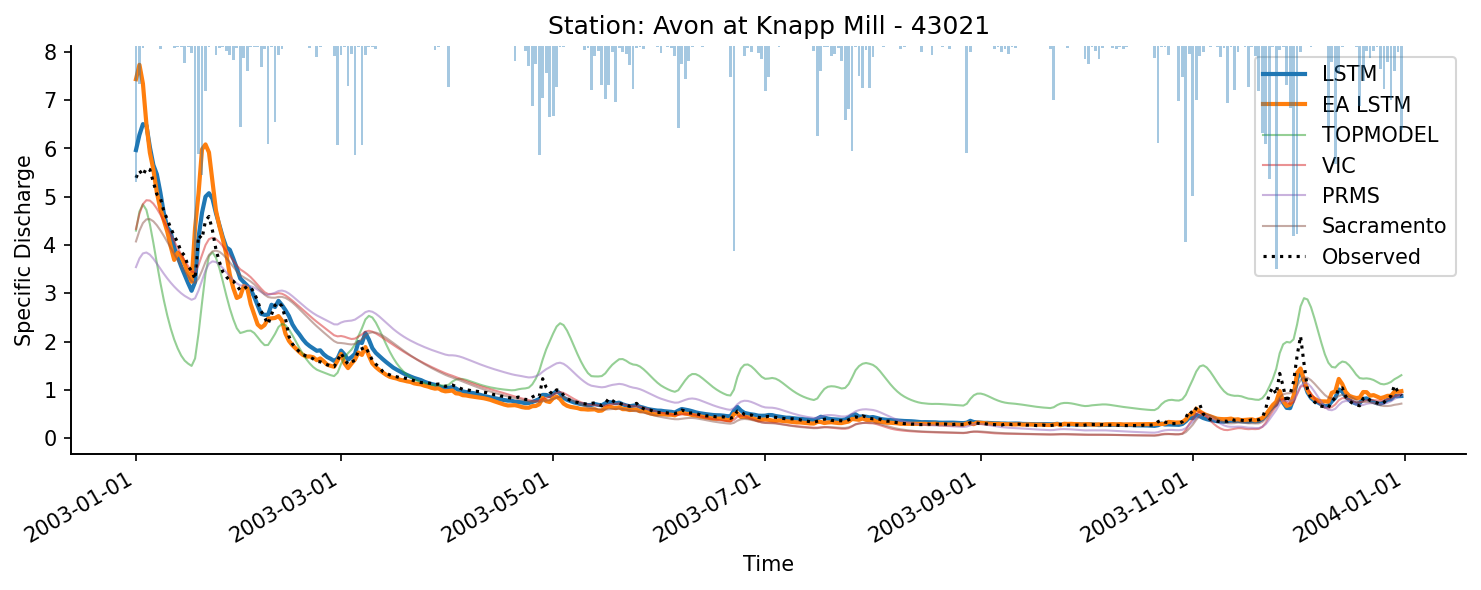

In [40]:

data = df.loc["2003"]
data = data.reset_index()

f, ax = plt.subplots(figsize=(12, 4))
plot_station_hydrograph(data, station_max_variance, ax=ax);

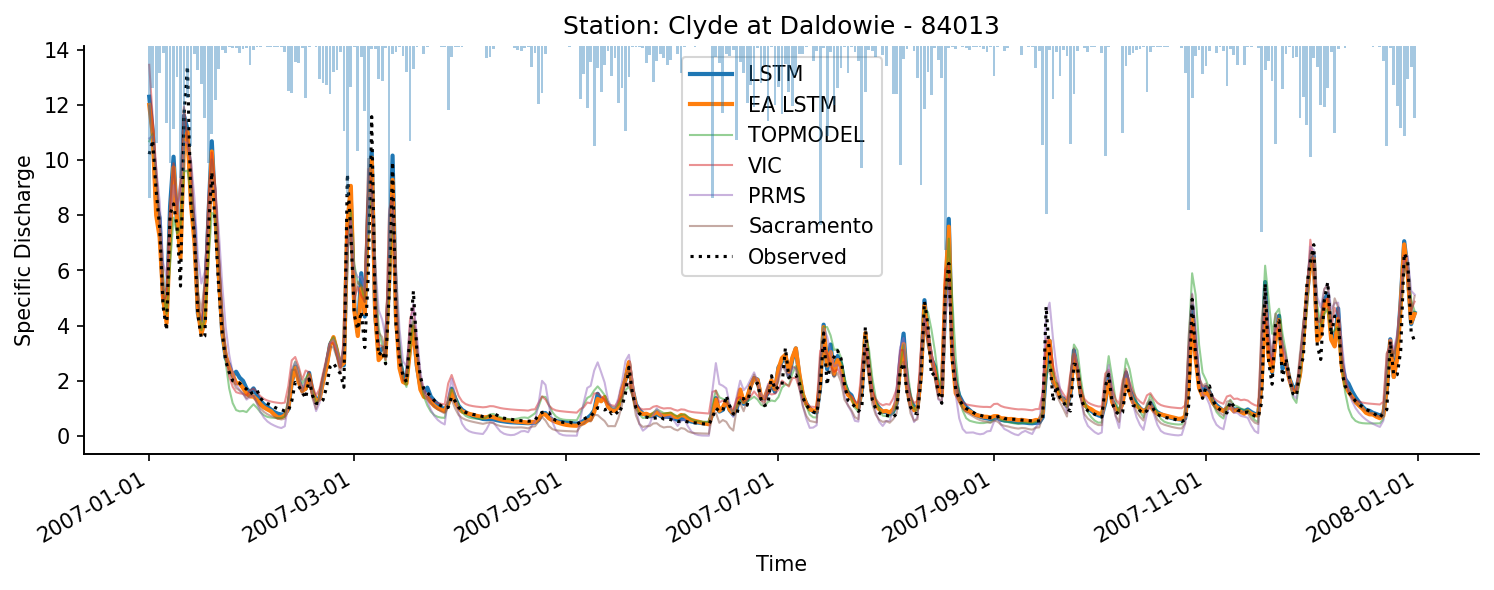

In [33]:
stations = np.array([station_med_variance[0]])
data = get_all_data_for_basins(stations=stations).reset_index().set_index(["time"]).drop("station_id", axis=1)

data = data.loc["2007"]
data = data.reset_index()

f, ax = plt.subplots(figsize=(12, 4))
plot_station_hydrograph(data, station_med_variance[0], ax=ax);

# Show most Arid Basin

In [34]:
static_df = static.to_dataframe()
# MAX
arid_sid = static_df.loc[static_df["aridity"].idxmax()].name
# MEDIAN
median_aridity = static_df.loc[static_df["aridity"] == static_df["aridity"].median()]["aridity"]
arid_sid = median_aridity.index[1]
arid_sid

station_name = static_df.loc[arid_sid, "gauge_name"]

In [35]:
from scripts.drafts.calculate_error_scores import DeltaError

# calculate all error metrics
processor = DeltaError(ealstm_preds, lstm_preds, fuse_data)
all_preds = processor.all_preds

In [36]:
arid_df = all_preds.sel(station_id=arid_sid).to_dataframe()
arid_df.head()

,station_id,TOPMODEL,ARNOVIC,PRMS,SACRAMENTO,EALSTM,obs,LSTM
time,,,,,,,,
1998-01-01,27042,3.1748,4.2562,5.2255,4.2105,3.852862,4.05,3.548202
1998-01-02,27042,4.3034,5.2662,6.1630,5.1635,5.345387,3.92,5.598096
1998-01-03,27042,4.7921,5.4177,6.3632,5.2014,4.943532,5.39,5.086295
1998-01-04,27042,5.3262,5.9574,6.8378,5.8109,5.688413,5.81,5.659703
1998-01-05,27042,4.8800,5.2067,6.2019,4.7444,5.156095,4.56,4.974656


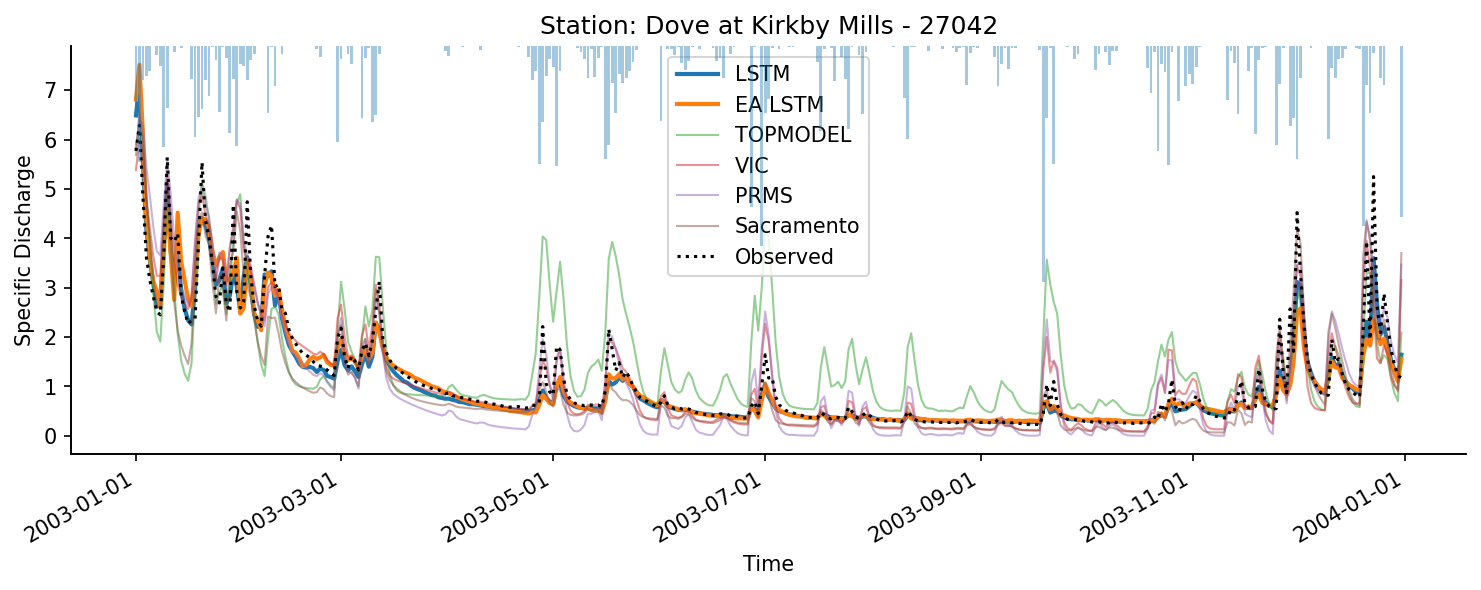

In [37]:
f, ax = plt.subplots(figsize=(12, 4))

data = arid_df.loc["2003"].drop("station_id", axis=1)
data = data.reset_index()
plot_station_hydrograph(data, arid_sid, ax=ax);

# The basins where we do worse than conceptual
- see DeltaNSE analysis notebook (f)

In [38]:
import geopandas as gpd

worse_basins = [5003, 21016, 21023, 27025, 27035, 28012, 28015, 28050, 32006, 33039, 33054, 34004, 34008, 39012, 39105, 40004, 40018, 41001, 41003, 41004, 41019, 42010, 42016, 43021, 54015, 54052, 54063, 67033, 68005, 68020, 80004, 84016, 92001]
worse_in_all_basins = [41019, 27035, 54052]

gdf = gpd.read_file(data_dir/"RUNOFF/point_shp.shp")
gdf = gdf.reset_index().astype({"ID": "int64", "index": "float64"}).set_index("ID")

NameError: name 'sid' is not defined

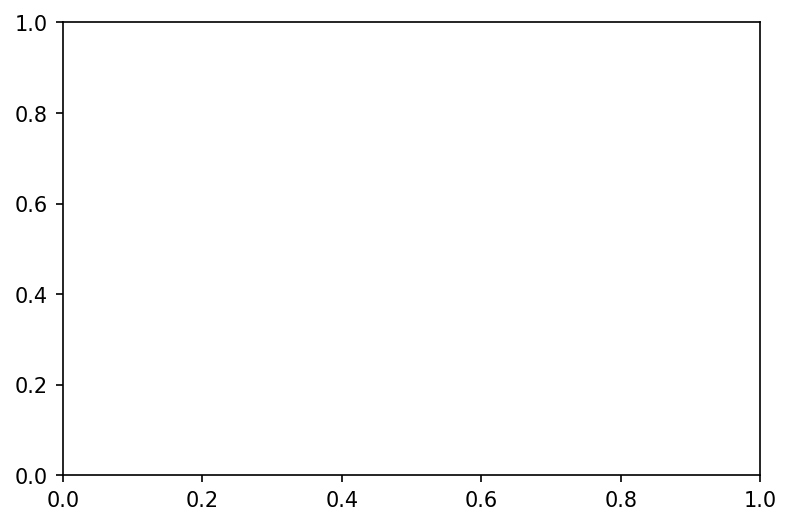

In [39]:
f, ax = plt.subplots()
gdf.loc[[s for s in gdf.index if s != sid]].plot("index", color="grey", markersize=10, alpha=0.8, ax=ax)
for ix, sid in enumerate(worse_in_all_basins):
    gdf.loc[[sid]].plot("index", ax=ax, label=sid, color=sns.color_palette()[ix])

ax.axis('off')
ax.legend()

In [ ]:
sid = worse_in_all_basins[0]
for sid in worse_in_all_basins:
    f, ax = plt.subplots(figsize=(12, 4))

    data = all_preds.sel(station_id=sid, time=slice("2000", "2001")).to_dataframe().reset_index()
    f, ax = plot_station_hydrograph(
        data, sid, ax=ax
    );

In [ ]:
# check the test data
dynamic.sel(station_id=sid, time=slice("1987", "1997"))

# LSTM Errors

In [ ]:
PLOT_ALL = False

In [ ]:
if PLOT_ALL:
    fig, axs = plot_catchment_time_series(
        df=lstm_less_vars.set_index("time").rename({"obs": "discharge_spec", "sim": "preds"}, axis=1),
        metrics_df=lstm_df,
        catchment_ids=catchment_ids,
        catchment_names=catchment_names,
        plot_years=[2008],
        color_by_season=True,
    );
    sns.despine()
    
else:
    for idx, name in summary_stations:
        fig, axs = plot_catchment_time_series(
            df=lstm_df.set_index("time").rename({"obs": "discharge_spec", "sim": "preds"}, axis=1),
            metrics_df=lstm_metric_df,
            catchment_ids=[idx],
            catchment_names=[name],
            plot_years=[2008],
            color_by_season=True,
        );
        sns.despine()

# EALSTM Errors

In [ ]:
if PLOT_ALL:
    fig, axs = plot_catchment_time_series(
        df=ealstm_df.set_index("time").rename({"obs": "discharge_spec", "sim": "preds"}, axis=1),
        metrics_df=ealstm_metric_df,
        catchment_ids=catchment_ids,
        catchment_names=catchment_names,
        plot_years=[2008],
        color_by_season=True,
    );
    
else:
    for idx, name in summary_stations:
        fig, axs = plot_catchment_time_series(
            df=ealstm_df.set_index("time").rename({"obs": "discharge_spec", "sim": "preds"}, axis=1),
            metrics_df=ealstm_metric_df,
            catchment_ids=[idx],
            catchment_names=[name],
            plot_years=[2008],
            color_by_season=True,
        );
    

In [ ]:
df.head()





In [ ]:
# Plot N random stations
N_STATIONS = 5
plot_conceptual = True

stations = np.random.choice(lstm_preds.station_id.values, N_STATIONS)
df = lstm_preds.sel(station_id=stations, time=(lstm_preds['time.year'] == 2007)).to_dataframe().rename({"sim": "LSTM"}, axis=1)
e_df = (
    ealstm_preds.sel(station_id=stations, time=(ealstm_preds['time.year'] == 2007)).to_dataframe()
    .drop("obs", axis=1).rename({"sim": "EALSTM"}, axis=1)
)
f_df = (
    fuse_ds.sel(station_id=stations[np.isin(stations, fuse_ds.station_id)], time=(fuse_ds['time.year'] == 2007)).to_dataframe()
)
data = (df.join(e_df).join(f_df)).reset_index().set_index("station_id")


f, axs = plt.subplots(N_STATIONS, 1, figsize=(12, 3*N_STATIONS))
for ix, station in enumerate(stations):
    ax = axs[ix]
    df = data.loc[station]
    ax.plot(np.arange(len(df)), df["LSTM"], color=sns.color_palette()[0], label="LSTM", alpha=1, linewidth=1)
    ax.plot(np.arange(len(df)), df["EALSTM"], color=sns.color_palette()[1], label="EA LSTM", alpha=1, linewidth=1)
    if plot_conceptual:
        ax.plot(np.arange(len(df)), df["SimQ_TOPMODEL"], color=sns.color_palette()[0], label="TOPMODEL", alpha=0.5, linewidth=1)
        ax.plot(np.arange(len(df)), df["SimQ_ARNOVIC"], color=sns.color_palette()[1], label="VIC", alpha=0.5, linewidth=1)
        ax.plot(np.arange(len(df)), df["SimQ_PRMS"], color=sns.color_palette()[0], label="PRMS", alpha=0.5, linewidth=1)
        ax.plot(np.arange(len(df)), df["SimQ_SACRAMENTO"], color=sns.color_palette()[1], label="Sacramento", alpha=0.5, linewidth=1)
        
    ax.plot(np.arange(len(df)), df["obs"], color="k", ls=":", label="Observed")
    ax.set_xticks([])
    ax.set_xticklabels([""])
    ax.set_ylabel(f"{station}")
    if ix == 0:
        ax.legend()
    if ix == N_STATIONS - 1:
        ax.set_xlabel("Time")
sns.despine()

# Comparison of ML Model Predictions

In [ ]:
stations

In [ ]:
def join_ml_preds(station: int, year: int = 2007):
    # lstm ensemble
    d1 = lstm_ensemble.sel(station_id=station, time=(lstm_ensemble['time.year'] == year)).to_dataframe().reset_index().set_index(["time", "station_id"]).rename({"sim": "ensemble_lstm"}, axis=1)
    # lstm 
    d2 = lstm_preds.sel(station_id=station, time=(lstm_preds['time.year'] == year)).to_dataframe().drop("obs", axis=1).reset_index().set_index(["time", "station_id"]).rename({"sim": "lstm"}, axis=1)
    # ealstm
    d3 = ealstm_preds.sel(station_id=station, time=(ealstm_preds['time.year'] == year)).to_dataframe().drop("obs", axis=1).reset_index().set_index(["time", "station_id"]).rename({"sim": "ealstm"}, axis=1)

    df = d1.join(d2).join(d3)
    return df

In [ ]:
stations = np.random.choice(lstm_ensemble.station_id.values, 10)

f, axs = plt.subplots(10, 1, figsize=(12, 2*10))
for ix, station in enumerate(stations):
    ax = axs[ix]
    # df = lstm_ensemble.sel(station_id=station, time=(lstm_ensemble['time.year'] == 2007)).to_dataframe()
    df = join_ml_preds(station, year=2007)
    ax.plot(np.arange(len(df)), df["obs"], color="k", ls=":", label="Observed")
    ax.plot(np.arange(len(df)), df["lstm"], color=sns.color_palette()[0], label="LSTM")
    ax.plot(np.arange(len(df)), df["ealstm"], color=sns.color_palette()[1], label="EALSTM")
    ax.plot(np.arange(len(df)), df["ensemble_lstm"], color=sns.color_palette()[2], label="Ensemble LSTM")
    ax.set_xticks([])
    ax.set_xticklabels([""])
    ax.set_ylabel(f"{station}")
    if ix == 0:
        ax.legend()
    if ix == 9:
        ax.set_xlabel("Time")
sns.despine()

# PRMS

# TOPMODEL

# VIC

# SACRAMENTO